# Result Notebook

In [31]:
import os
import json

import numpy as np
import pylab as plt
import pandas as pd

from tqdm.auto import tqdm
from pathlib import Path
from omegaconf import OmegaConf

result_path = Path('results')

In [32]:
%%bash
mkdir -p results
fusermount -uz results
sshfs compute.ies:/mnt/work/dhuseljic/results/uncertainty_evaluation results
ls results

ablations
all_samples
few_samples


In [33]:
# Define loading functions
def load_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def load_results(path, train_results=False):
    results = {}

    exp_json = path / 'results_final.json'
    exp_cfg = path / '.hydra' / 'config.yaml'
    try:
        cfg =  OmegaConf.load(exp_cfg)
        data = load_json(exp_json)
        result_dict_final_epoch = data['test_history'][-1]
        if train_results:
            result_dict_final_epoch = data['train_history'][-1]

        results['cfg'] = cfg
        results['results'] = result_dict_final_epoch 
    except:
        print(f'{path} has missing results.')
    return results

def get_experiments(result_path, glob_pattern, train_results=False):
    experiments = []
    for exp_path in result_path.glob(glob_pattern):
        d = load_results(exp_path, train_results=train_results)
        experiments.append(d)
    return experiments

def get_metric_dict(experiments, metrics=None, ignore_metrics=[], return_std=False):
    metric_names = list(experiments[0]['results'].keys())
    d = {}
    for metric_name in metric_names:
        if metrics is not None:
            if metric_name not in metrics:
                continue
        if metric_name in ignore_metrics:
            continue
        value = np.mean([exp['results'][metric_name] for exp in experiments])
        d[metric_name] = value
        if return_std:
            std = np.std([exp['results'][metric_name] for exp in experiments])
            d[metric_name+'_std'] = std
    if len(d) == 0:
        raise ValueError('Specify at least one of the following metrics {}'.format(metric_names))
    return d
# experiments = get_experiments(result_path / 'CIFAR10__resnet18', glob_pattern='seed*')
# print(f'Found {len(experiments)} experiments')
# get_metric_dict(experiments)

In [34]:
# for each seed, check if the training indices are equal
def check_train_indices(exp1_path, exp2_path, n_seeds=5):
    """Checks the train indices of two different experiments"""
    for seed in range(1, n_seeds+1):
        p1 = exp1_path / f'seed{seed}' 
        p2 = exp2_path / f'seed{seed}'
        # TODO Change
        results1 = load_results(p1)
        results2 = load_results(p2)
        print(results1['results'].keys())

        # if not torch.all(indices1 == indices2):
        #     print(f'{p1} and {p2} seem to have different training sets.')

## General Results - All Samples

### Wide-Resnet 28-10

In [5]:
metrics = ['test_acc1', 'test_nll', 'test_tce', 'test_SVHN_entropy_auroc',]
exp_names = {
    'deterministic': 'all_samples/CIFAR10__wideresnet2810',
    "dropout": "all_samples/CIFAR10__wideresnet2810_mcdropout",
    "ensemble": "all_samples/CIFAR10__wideresnet2810_ensemble",
    "sngp": "all_samples/CIFAR10__wideresnet2810_sngp",
}

data = []
for key, name in exp_names.items():
    experiments = get_experiments(result_path / name, glob_pattern='seed*')
    metric_dict = get_metric_dict(experiments, metrics=metrics, return_std=False)
    data.append(metric_dict)

df = pd.DataFrame(data, index=exp_names.keys())
df = df.rename(mapper=lambda x: x.split('_')[-1], axis='columns')
print(df.to_markdown(floatfmt='0.3f'))

|               |   acc1 |   nll |   tce |   auroc |
|:--------------|-------:|------:|------:|--------:|
| deterministic | 96.446 | 0.128 | 0.016 |   0.932 |
| dropout       | 96.400 | 0.127 | 0.015 |   0.958 |
| ensemble      | 96.886 | 0.098 | 0.007 |   0.976 |
| sngp          | 96.292 | 0.123 | 0.005 |   0.960 |


### ResNet18

In [85]:
metrics = ['test_acc1', 'test_nll', 'test_tce', 'test_SVHN_entropy_auroc',]
exp_names = {
    'deterministic': 'all_samples/CIFAR10__resnet18',
    "dropout": "all_samples/CIFAR10__resnet18_mcdropout",
    "sngp": "all_samples/CIFAR10__resnet18_sngp",
}

data = []
for key, name in exp_names.items():
    experiments = get_experiments(result_path / name, glob_pattern='seed*')
    metric_dict = get_metric_dict(experiments, metrics=metrics, return_std=False)
    data.append(metric_dict)

df = pd.DataFrame(data, index=exp_names.keys())
df = df.rename(mapper=lambda x: x.split('_')[-1], axis='columns')
print(df.to_markdown(floatfmt='.3f'))

|               |   acc1 |   nll |   tce |   auroc |
|:--------------|-------:|------:|------:|--------:|
| deterministic | 95.300 | 0.193 | 0.029 |   0.936 |
| dropout       | 94.420 | 0.171 | 0.006 |   0.932 |
| sngp          | 95.094 | 0.161 | 0.006 |   0.961 |


## Low Data Regime
Experimental Setup:
- Dataset is CIFAR10
- increase number of samples
- SNGP `kernel_scale` was set to 90

In [11]:
metrics = ['test_acc1', 'test_nll', 'test_tce', 'test_SVHN_entropy_auroc',]
results = []
all_n_samples = np.arange(100, 2000, 100).tolist() + [3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
for n_samples in tqdm(all_n_samples):
    exp_names = {
        'deterministic': f'few_samples/CIFAR10/resnet18/{n_samples}samples',
        'dropout': f'few_samples/CIFAR10/resnet18_mcdropout/{n_samples}samples',
        "sngp": f'few_samples/CIFAR10/resnet18_sngp/{n_samples}samples',
    }

    # Check train indices
    # for key1 in exp_names:
    #     for key2 in exp_names:
    #         if key1 == key2: continue
    #         check_train_indices(result_path / exp_names[key1], result_path / exp_names[key2])

    data = []
    for key, name in exp_names.items():
        experiments = get_experiments(result_path / name, glob_pattern='seed*')
        metric_dict = get_metric_dict(experiments, metrics=metrics, return_std=False)
        data.append(metric_dict)

    df = pd.DataFrame(data, index=exp_names.keys())
    df = df.rename(columns={key: f"{key.split('_')[-1]}" for key in df.keys()})
    # display(df)
    # print(f'`n_samples = {n_samples}`')
    # print(df.to_markdown(floatfmt='.2f'))
    results.append(df.to_dict())

100%|██████████| 27/27 [02:32<00:00,  5.63s/it]


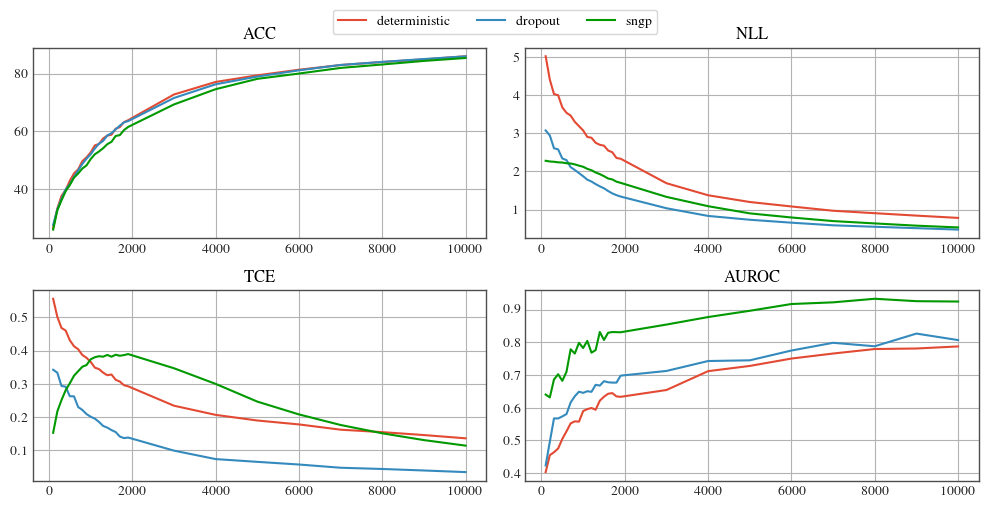

In [12]:
import pylab as plt
fig = plt.figure()
plt.subplot(221)
plt.title('ACC')
tmp = [d['acc1'] for d in results]
plt.plot(all_n_samples, [d['deterministic'] for d in tmp], label='deterministic')
plt.plot(all_n_samples, [d['dropout'] for d in tmp], label='dropout')
plt.plot(all_n_samples, [d['sngp'] for d in tmp], label='sngp')
fig.legend(loc='upper center', ncol=5, bbox_to_anchor=(.5, 1.02))

plt.subplot(222)
plt.title('NLL')
tmp = [d['nll'] for d in results]
plt.plot(all_n_samples, [d['deterministic'] for d in tmp])
plt.plot(all_n_samples, [d['dropout'] for d in tmp], label='dropout')
plt.plot(all_n_samples, [d['sngp'] for d in tmp])

plt.subplot(223)
plt.title('TCE')
tmp = [d['tce'] for d in results]
plt.plot(all_n_samples, [d['deterministic'] for d in tmp])
plt.plot(all_n_samples, [d['dropout'] for d in tmp], label='dropout')
plt.plot(all_n_samples, [d['sngp'] for d in tmp])

plt.subplot(224)
plt.title('AUROC')
tmp = [d['auroc'] for d in results]
plt.plot(all_n_samples, [d['deterministic'] for d in tmp])
plt.plot(all_n_samples, [d['dropout'] for d in tmp], label='dropout')
plt.plot(all_n_samples, [d['sngp'] for d in tmp])
plt.tight_layout()
plt.show()

## SNGP

### Kernel Scale Ablation

In [29]:
metrics = ['test_acc1', 'test_nll', 'test_tce', 'test_SVHN_entropy_auroc',]
exp_names = {
    'scale=0.01': 'ablations/sngp/scale0.01_samples500/CIFAR10/',
    'scale=0.1': 'ablations/sngp/scale0.1_samples500/CIFAR10/',
    'scale=1': 'ablations/sngp/scale1_samples500/CIFAR10/',
    'scale=10': 'ablations/sngp/scale10_samples500/CIFAR10/',
    'scale=20': 'ablations/sngp/scale20_samples500/CIFAR10/',
    'scale=30': 'ablations/sngp/scale30_samples500/CIFAR10/',
    'scale=40': 'ablations/sngp/scale40_samples500/CIFAR10/',
    'scale=50': 'ablations/sngp/scale50_samples500/CIFAR10/',
    'scale=60': 'ablations/sngp/scale60_samples500/CIFAR10/',
    'scale=70': 'ablations/sngp/scale70_samples500/CIFAR10/',
    'scale=80': 'ablations/sngp/scale80_samples500/CIFAR10/',
    'scale=90': 'ablations/sngp/scale90_samples500/CIFAR10/',
    'scale=100': 'ablations/sngp/scale100_samples500/CIFAR10/',
    'scale=110': 'ablations/sngp/scale110_samples500/',
    'scale=120': 'ablations/sngp/scale120_samples500/',
    'scale=130': 'ablations/sngp/scale130_samples500/',
    'scale=140': 'ablations/sngp/scale140_samples500/',
    'scale=150': 'ablations/sngp/scale150_samples500/',
    'scale=160': 'ablations/sngp/scale160_samples500/',
    'scale=170': 'ablations/sngp/scale170_samples500/',
    'scale=180': 'ablations/sngp/scale180_samples500/',
    'scale=190': 'ablations/sngp/scale190_samples500/',
    'scale=200': 'ablations/sngp/scale200_samples500/',
    'scale=210': 'ablations/sngp/scale210_samples500/',
    'scale=220': 'ablations/sngp/scale220_samples500/',
    'scale=230': 'ablations/sngp/scale230_samples500/',
    'scale=240': 'ablations/sngp/scale240_samples500/',
    'scale=250': 'ablations/sngp/scale250_samples500/',
    'scale=260': 'ablations/sngp/scale260_samples500/',
    'scale=270': 'ablations/sngp/scale270_samples500/',
    'scale=280': 'ablations/sngp/scale280_samples500/',
    'scale=290': 'ablations/sngp/scale290_samples500/',
    'scale=300': 'ablations/sngp/scale300_samples500/',
}

data = []
for key in tqdm(exp_names):
    experiments = get_experiments(result_path / exp_names[key], glob_pattern='seed*')
    metric_dict = get_metric_dict(experiments, metrics=metrics, return_std=False)
    data.append(metric_dict)

df = pd.DataFrame(data, index=exp_names.keys())
df = df.rename(mapper=lambda x: x.split('_')[-1], axis='columns')
display(df)
print(df.to_markdown(floatfmt='0.3f'))
    
baseline_path = 'ablations/CIFAR10__resnet18__500samples'
baseline_experiments = get_experiments(result_path / baseline_path, glob_pattern='seed*')
baseline_results= get_metric_dict(baseline_experiments, metrics=metrics, return_std=False)

100%|██████████| 33/33 [02:39<00:00,  4.84s/it]


,acc1,nll,tce,auroc
scale=0.01,14.486000,2.300069,0.044744,0.414220
scale=0.1,26.604999,2.270271,0.158109,0.526541
scale=1,31.896999,2.184667,0.193327,0.581027
scale=10,34.744999,1.980141,0.156494,0.630142
scale=20,35.845999,1.907166,0.132646,0.605302
scale=30,35.866999,1.869502,0.104051,0.599960
scale=40,36.143999,1.846242,0.081119,0.616604
scale=50,36.377999,1.820462,0.057188,0.616877
scale=60,36.902999,1.801442,0.050958,0.632091
scale=70,36.375999,1.804045,0.027882,0.628525


|            |   acc1 |   nll |   tce |   auroc |
|:-----------|-------:|------:|------:|--------:|
| scale=0.01 | 14.486 | 2.300 | 0.045 |   0.414 |
| scale=0.1  | 26.605 | 2.270 | 0.158 |   0.527 |
| scale=1    | 31.897 | 2.185 | 0.193 |   0.581 |
| scale=10   | 34.745 | 1.980 | 0.156 |   0.630 |
| scale=20   | 35.846 | 1.907 | 0.133 |   0.605 |
| scale=30   | 35.867 | 1.870 | 0.104 |   0.600 |
| scale=40   | 36.144 | 1.846 | 0.081 |   0.617 |
| scale=50   | 36.378 | 1.820 | 0.057 |   0.617 |
| scale=60   | 36.903 | 1.801 | 0.051 |   0.632 |
| scale=70   | 36.376 | 1.804 | 0.028 |   0.629 |
| scale=80   | 37.013 | 1.782 | 0.021 |   0.626 |
| scale=90   | 36.696 | 1.787 | 0.018 |   0.625 |
| scale=100  | 36.447 | 1.789 | 0.030 |   0.599 |
| scale=110  | 37.205 | 1.789 | 0.037 |   0.618 |
| scale=120  | 37.020 | 1.795 | 0.047 |   0.604 |
| scale=130  | 36.171 | 1.814 | 0.057 |   0.608 |
| scale=140  | 36.608 | 1.813 | 0.071 |   0.589 |
| scale=150  | 36.266 | 1.827 | 0.074 |   0.587 |


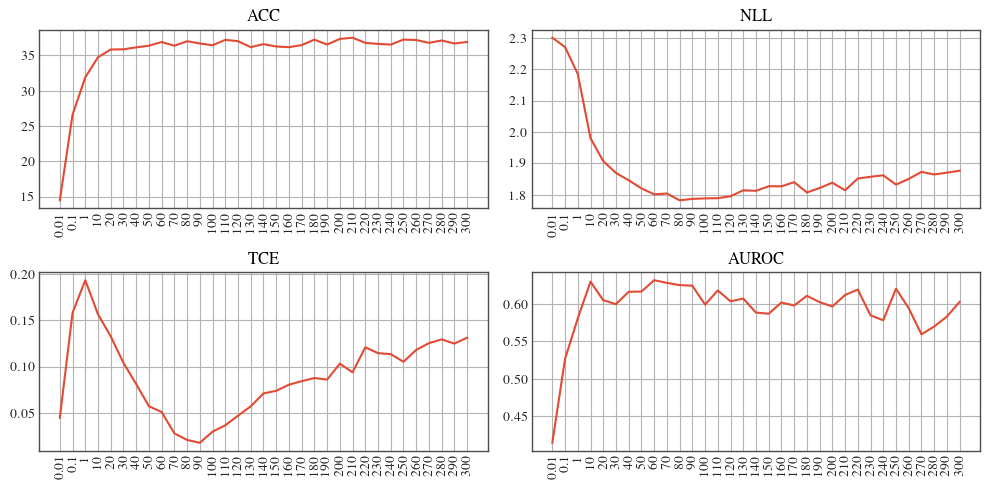

In [30]:
plot_baseline = False
scales = [key.split('=')[-1] for key in exp_names.keys()]
plt.figure()

plt.subplot(221)
plt.title('ACC')
plt.plot(scales, [d['test_acc1'] for d in data])
if plot_baseline:
    plt.hlines(baseline_results['test_acc1'], min(scales), max(scales), colors='k', linestyles='--')
plt.xticks(rotation=90)

plt.subplot(222)
plt.title('NLL')
plt.plot(scales, [d['test_nll'] for d in data])
if plot_baseline:
    plt.hlines(baseline_results['test_nll'], min(scales), max(scales), colors='k', linestyles='--')
plt.xticks(rotation=90)

plt.subplot(223)
plt.title('TCE')
plt.plot(scales, [d['test_tce'] for d in data])
if plot_baseline:
    plt.hlines(baseline_results['test_tce'], min(scales), max(scales), colors='k', linestyles='--')
plt.xticks(rotation=90)

plt.subplot(224)
plt.title('AUROC')
plt.plot(scales, [d['test_SVHN_entropy_auroc'] for d in data])
if plot_baseline:
    plt.hlines(baseline_results['test_SVHN_entropy_auroc'], min(scales), max(scales), colors='k', linestyles='--')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [16]:
metrics = ['test_acc1', 'test_nll', 'test_tce', 'test_SVHN_entropy_auroc',]
n_samples = 100
# scales = list(range(1, 100)) + [100, 125, 150, 175, 200]
scales = [1] + list(range(10, 110, 10))
exp_names = {f'scale={scale}': f'ablations/sngp/samples{n_samples}/scale{scale}/' for scale in scales}

data = []
for key in tqdm(exp_names):
    experiments = get_experiments(result_path / exp_names[key], glob_pattern='seed*')
    metric_dict = get_metric_dict(experiments, metrics=metrics, return_std=False)
    data.append(metric_dict)

df = pd.DataFrame(data, index=exp_names.keys())
df = df.rename(mapper=lambda x: x.split('_')[-1], axis='columns')
print(df.to_markdown(floatfmt='0.3f'))

100%|██████████| 11/11 [00:05<00:00,  1.88it/s]

|           |   acc1 |   nll |   tce |   auroc |
|:----------|-------:|------:|------:|--------:|
| scale=1   | 20.276 | 2.261 | 0.085 |   0.544 |
| scale=10  | 21.232 | 2.166 | 0.042 |   0.531 |
| scale=20  | 22.204 | 2.191 | 0.029 |   0.560 |
| scale=30  | 22.098 | 2.173 | 0.030 |   0.527 |
| scale=40  | 22.980 | 2.183 | 0.049 |   0.491 |
| scale=50  | 22.568 | 2.217 | 0.055 |   0.487 |
| scale=60  | 22.614 | 2.225 | 0.056 |   0.457 |
| scale=70  | 22.072 | 2.240 | 0.079 |   0.483 |
| scale=80  | 23.166 | 2.235 | 0.069 |   0.498 |
| scale=90  | 23.170 | 2.212 | 0.070 |   0.555 |
| scale=100 | 22.498 | 2.270 | 0.100 |   0.456 |


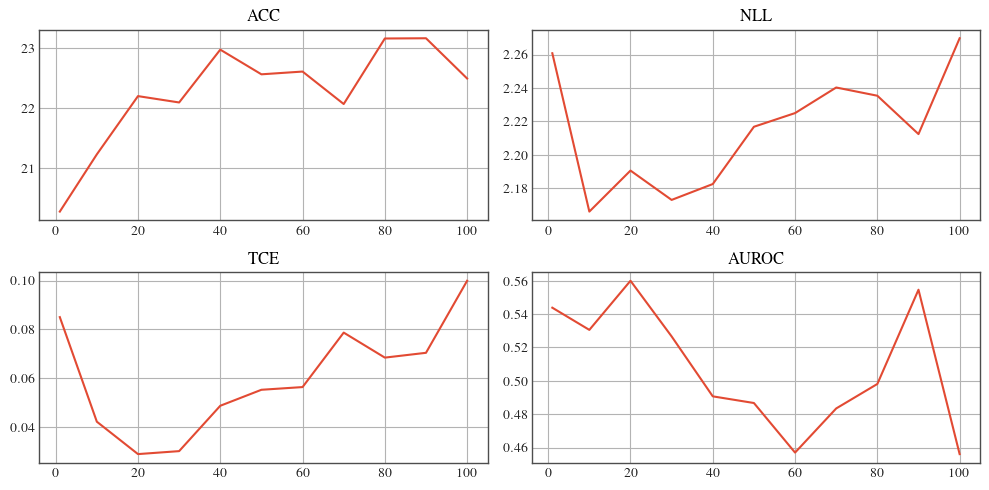

In [17]:
plt.subplot(221)
plt.title('ACC')
plt.plot(scales, [d['test_acc1'] for d in data])
plt.subplot(222)
plt.title('NLL')
plt.plot(scales, [d['test_nll'] for d in data])
plt.subplot(223)
plt.title('TCE')
plt.plot(scales, [d['test_tce'] for d in data])
plt.subplot(224)
plt.title('AUROC')
plt.plot(scales, [d['test_SVHN_entropy_auroc'] for d in data])
plt.tight_layout()
plt.show()
    
# baseline_path = 'ablations/CIFAR10__resnet18__500samples'
# baseline_experiments = get_experiments(result_path / baseline_path, glob_pattern='seed*')
# baseline_results= get_metric_dict(baseline_experiments, metrics=metrics, return_std=False)

In [8]:
metrics = ['train_acc1', 'train_loss']
n_samples = 100
scales = list(range(1, 100)) + [100, 125, 150, 175, 200]
exp_names = {f'scale={scale}': f'ablations/sngp/samples{n_samples}/scale{scale}/' for scale in scales}

data = []
for key in tqdm(exp_names):
    experiments = get_experiments(result_path / exp_names[key], glob_pattern='seed*', train_results=True)
    metric_dict = get_metric_dict(experiments, metrics=metrics, return_std=False)
    data.append(metric_dict)

df = pd.DataFrame(data, index=exp_names.keys())
df = df.rename(mapper=lambda x: x.split('_')[-1], axis='columns')
print(df.to_markdown(floatfmt='0.3f'))

 21%|██        | 22/104 [00:33<02:00,  1.48s/it]

results/ablations/sngp/samples100/scale23/seed5 has missing results.


 21%|██        | 22/104 [00:35<02:10,  1.60s/it]


KeyError: 'results'

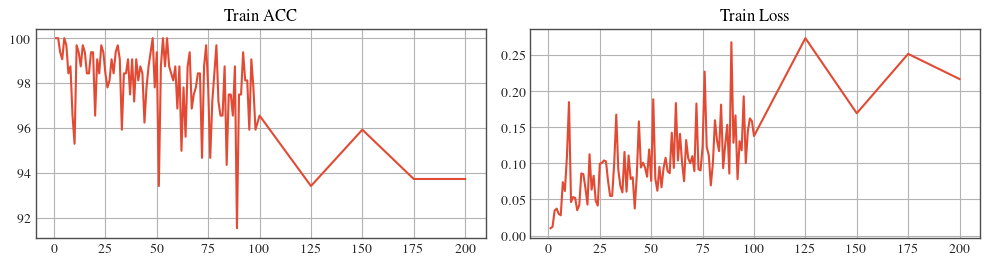

In [21]:
plt.subplot(221)
plt.title('Train ACC')
plt.plot(scales, [d['train_acc1'] for d in data])
plt.subplot(222)
plt.title('Train Loss')
plt.plot(scales, [d['train_loss'] for d in data])
plt.tight_layout()
plt.show()

### Learning Rate Ablation

In [22]:
metrics = ['test_acc1', 'test_nll', 'test_tce', 'test_SVHN_entropy_auroc',]
n_samples = 5000
# scales = list(range(1, 100)) + [100, 125, 150, 175, 200]
lrs = [
    0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
    0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
exp_names = {f'lr={lr}': f'ablations/sngp/samples{n_samples}/lr{lr}/' for lr in lrs}

data = []
for key in tqdm(exp_names):
    experiments = get_experiments(result_path / exp_names[key], glob_pattern='seed*')
    metric_dict = get_metric_dict(experiments, metrics=metrics, return_std=False)
    data.append(metric_dict)

df = pd.DataFrame(data, index=exp_names.keys())
df = df.rename(mapper=lambda x: x.split('_')[-1], axis='columns')
print(df.to_markdown(floatfmt='0.3f'))

100%|██████████| 15/15 [00:02<00:00,  6.18it/s]

|          |   acc1 |   nll |   tce |   auroc |
|:---------|-------:|------:|------:|--------:|
| lr=0.001 | 72.982 | 1.130 | 0.291 |   0.801 |
| lr=0.002 | 76.174 | 1.013 | 0.279 |   0.837 |
| lr=0.003 | 76.790 | 0.976 | 0.266 |   0.858 |
| lr=0.004 | 77.416 | 0.944 | 0.259 |   0.876 |
| lr=0.005 | 78.014 | 0.920 | 0.253 |   0.850 |
| lr=0.006 | 77.896 | 0.920 | 0.251 |   0.896 |
| lr=0.007 | 77.798 | 0.919 | 0.251 |   0.895 |
| lr=0.008 | 77.840 | 0.913 | 0.248 |   0.902 |
| lr=0.009 | 77.492 | 0.918 | 0.244 |   0.892 |
| lr=0.01  | 78.180 | 0.901 | 0.246 |   0.896 |
| lr=0.02  | 78.418 | 0.894 | 0.245 |   0.925 |
| lr=0.03  | 78.010 | 0.888 | 0.236 |   0.904 |
| lr=0.04  | 76.792 | 0.913 | 0.231 |   0.857 |
| lr=0.05  | 76.184 | 0.932 | 0.232 |   0.850 |
| lr=0.06  | 75.140 | 0.946 | 0.221 |   0.832 |


array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

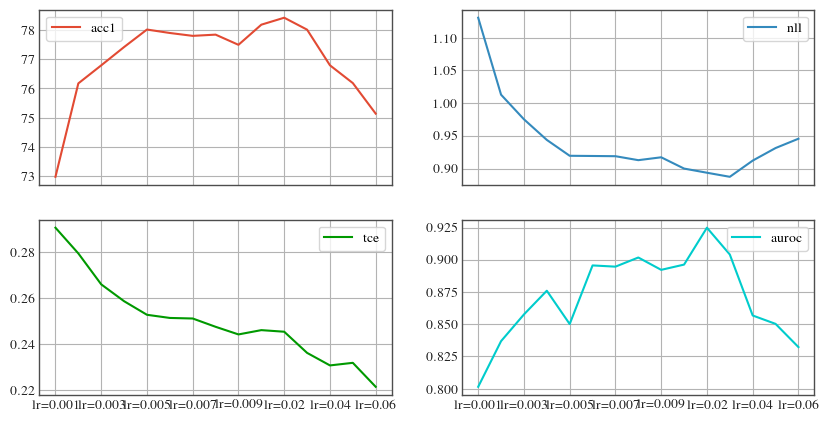

In [23]:
df.plot(subplots=True,layout=(2, 2))

### Weight Decay ablation

In [35]:
metrics = ['test_acc1', 'test_nll', 'test_tce', 'test_SVHN_entropy_auroc',]
n_samples = 1000
# scales = list(range(1, 100)) + [100, 125, 150, 175, 200]
wds = [
    0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009,
    0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01,
    0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1
]
wds = np.arange(0, .2, 0.01)
exp_names = {f'wd={wd}': f'ablations/sngp/samples{n_samples}/WD/{wd:.2f}/' for wd in wds}

data = []
for key in tqdm(exp_names):
    experiments = get_experiments(result_path / exp_names[key], glob_pattern='seed*')
    metric_dict = get_metric_dict(experiments, metrics=metrics, return_std=False)
    data.append(metric_dict)

df = pd.DataFrame(data, index=exp_names.keys())
df = df.rename(mapper=lambda x: x.split('_')[-1], axis='columns')
print(df.to_markdown(floatfmt='0.3f'))

100%|██████████| 20/20 [00:36<00:00,  1.84s/it]

|         |   acc1 |   nll |   tce |   auroc |
|:--------|-------:|------:|------:|--------:|
| wd=0.0  | 50.432 | 2.130 | 0.376 |   0.762 |
| wd=0.01 | 56.592 | 1.867 | 0.376 |   0.676 |
| wd=0.02 | 60.120 | 1.501 | 0.252 |   0.595 |
| wd=0.03 | 62.936 | 1.407 | 0.245 |   0.612 |
| wd=0.04 | 65.744 | 1.344 | 0.256 |   0.611 |
| wd=0.05 | 67.238 | 1.306 | 0.264 |   0.616 |
| wd=0.06 | 68.412 | 1.285 | 0.273 |   0.648 |
| wd=0.07 | 68.226 | 1.286 | 0.273 |   0.709 |
| wd=0.08 | 68.212 | 1.281 | 0.273 |   0.663 |
| wd=0.09 | 67.344 | 1.294 | 0.273 |   0.623 |
| wd=0.1  | 65.482 | 1.328 | 0.269 |   0.586 |
| wd=0.11 | 62.474 | 1.369 | 0.255 |   0.568 |
| wd=0.12 | 55.830 | 1.434 | 0.219 |   0.601 |
| wd=0.13 | 52.992 | 1.474 | 0.206 |   0.621 |
| wd=0.14 | 49.282 | 1.517 | 0.183 |   0.573 |
| wd=0.15 | 38.080 | 1.655 | 0.121 |   0.605 |
| wd=0.16 | 36.844 | 1.696 | 0.124 |   0.622 |
| wd=0.17 | 32.332 | 1.794 | 0.107 |   0.712 |
| wd=0.18 | 24.664 | 1.905 | 0.059 |   0.722 |
| wd=0.19 | 2

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

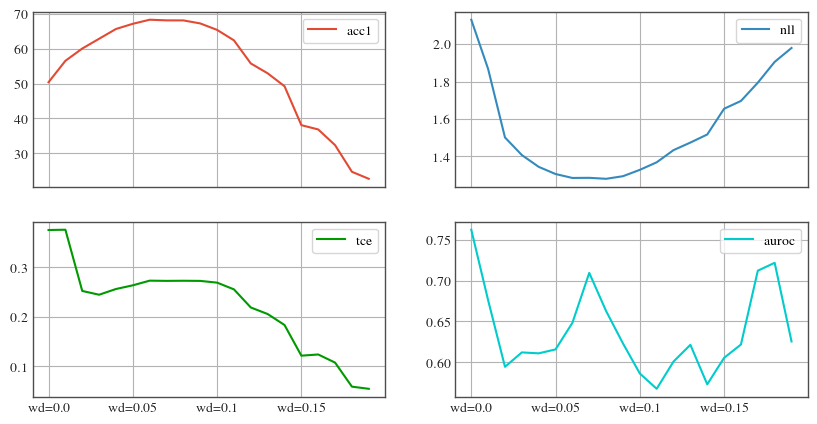

In [36]:
df.plot(subplots=True,layout=(2, 2))